In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\projetos\kaua\trabalho_topicos_5\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import zipfile
import pandas as pd
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, LeaveOneOut
pio.renderers.default = 'png'
# pio.renderers.default = 'notebook'

In [3]:
path_database = './database'
path_database_zip = f'{path_database}/breast-cancer-dataset.zip'
path_database_csv = f'{path_database}/breast-cancer.csv'
os.makedirs(path_database, exist_ok=True)

In [4]:
if not os.path.exists(path_database_zip):
    !curl -L -o {path_database_zip} https://www.kaggle.com/api/v1/datasets/download/yasserh/breast-cancer-dataset
zipfile.ZipFile(path_database_zip, 'r').extractall(path_database)

In [5]:
df_dataset = pd.read_csv(path_database_csv)
df_dataset['diagnosis'] = df_dataset['diagnosis'].map({'M': 'Maligno', 'B': 'Benigno'})
df_dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,Maligno,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,Maligno,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,Maligno,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,Maligno,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,Maligno,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
n_cols = 3
width_graph = 1200
n_rows = (len(df_dataset.columns) + n_cols - 1) // n_cols
color_maligono = '#FF5733'
color_benigno = '#33C1FF'

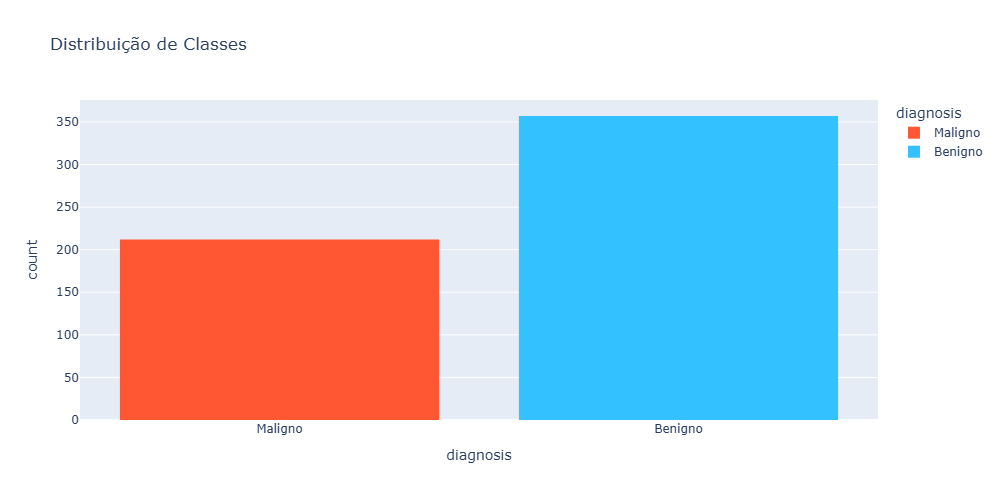

In [7]:
px.histogram(df_dataset, x='diagnosis', title='Distribuição de Classes', width=1000, color='diagnosis', color_discrete_map={'Maligno': color_maligono, 'Benigno': color_benigno})

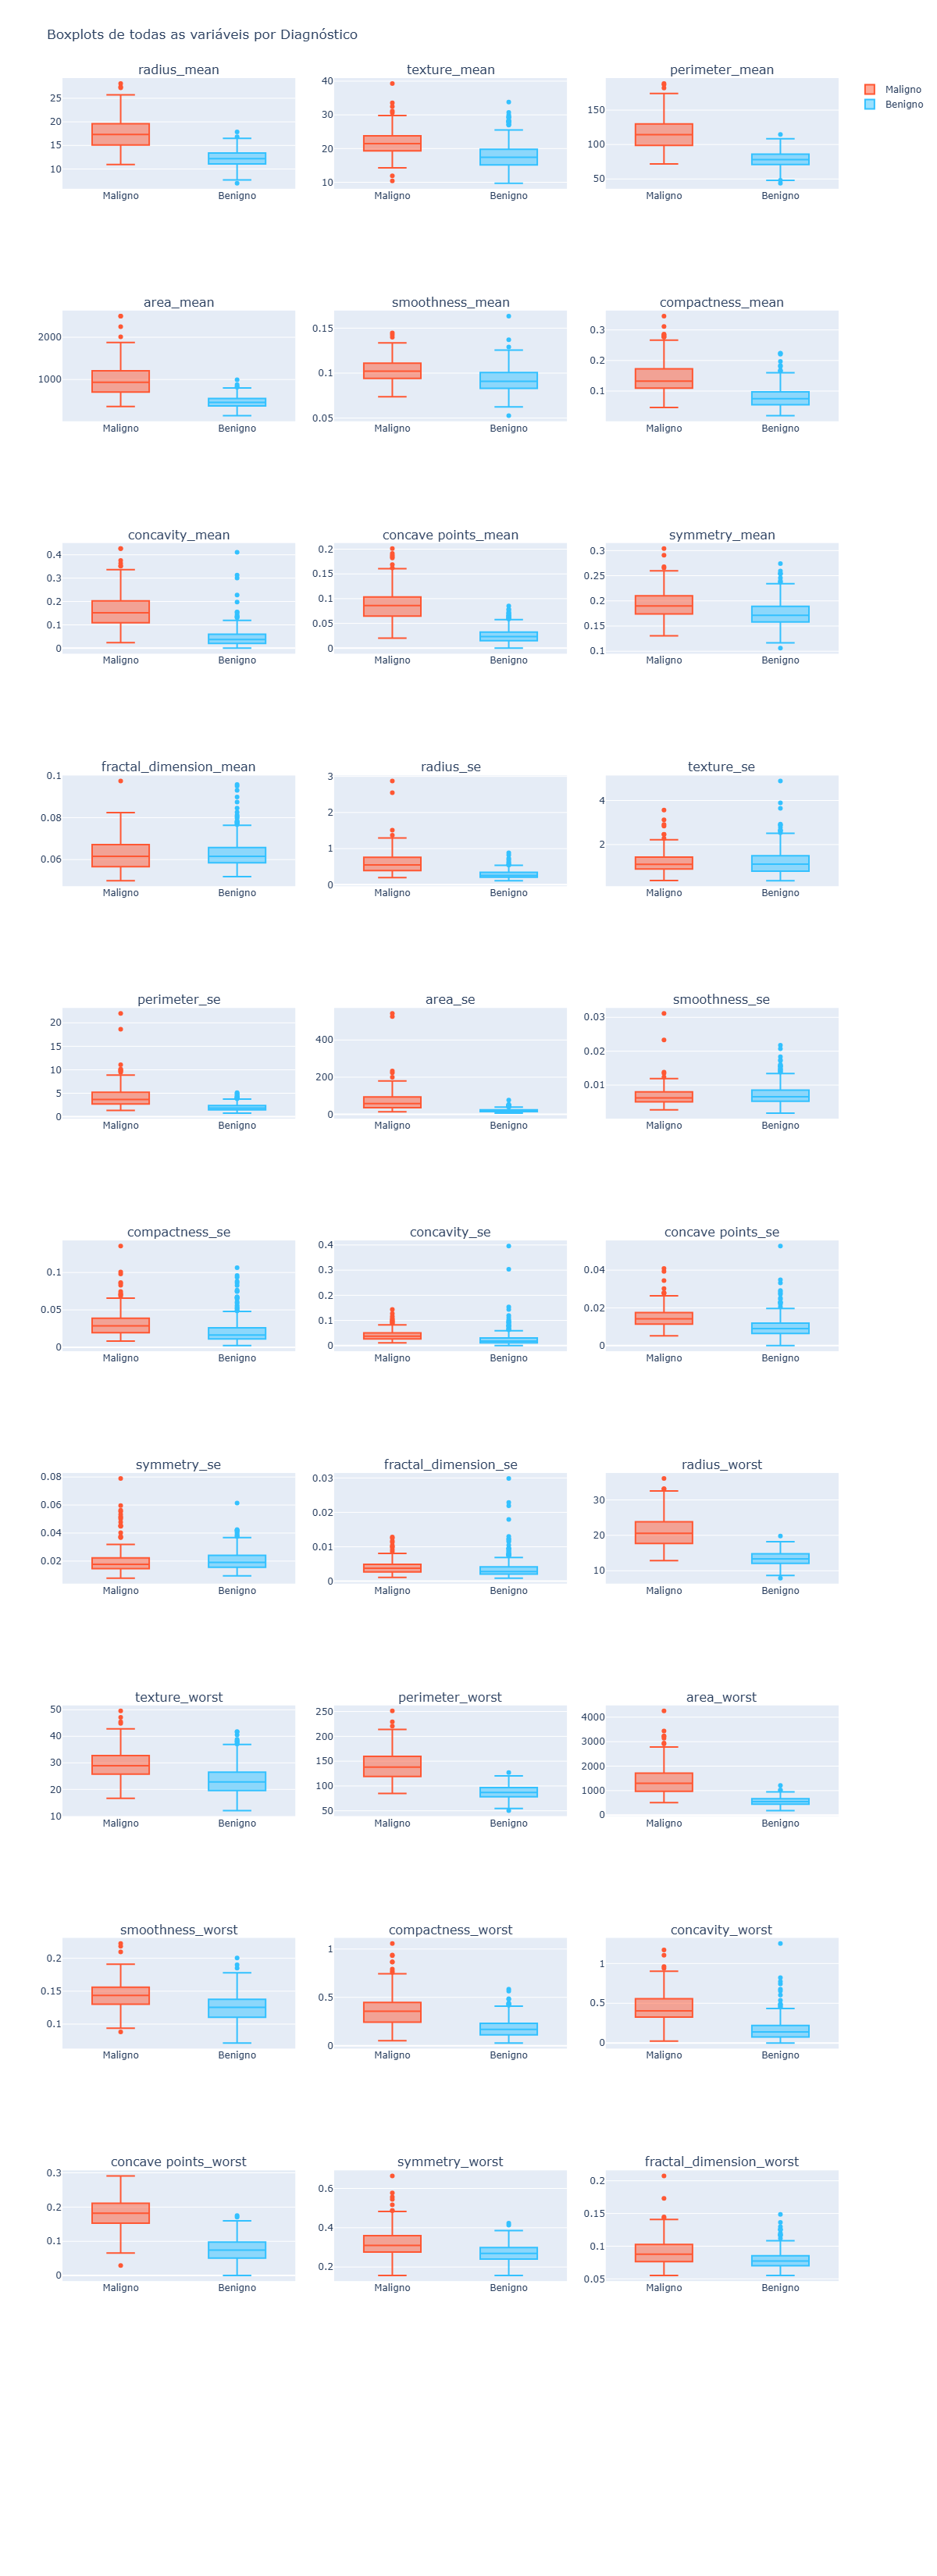

In [8]:
fig = make_subplots(
    rows=n_rows, 
    cols=n_cols,
    subplot_titles=df_dataset.columns[2:],
    vertical_spacing=0.05,   
    horizontal_spacing=0.05  
)

for idx, coluna in enumerate(df_dataset.columns[2:]):
    row = idx // n_cols + 1
    col = idx % n_cols + 1
    
    for diagnosis in df_dataset['diagnosis'].unique():
        df_filtrado = df_dataset[df_dataset['diagnosis'] == diagnosis]
        fig.add_trace(
            go.Box(y=df_filtrado[coluna], name=diagnosis, showlegend=(idx == 0), marker_color=color_maligono if diagnosis == 'Maligno' else color_benigno),
            row=row,
            col=col
        )

fig.update_layout(
    height=300 * n_rows,  # Reduzido para compactar mais
    width=width_graph,
    title_text="Boxplots de todas as variáveis por Diagnóstico",
    showlegend=True
)
fig.show()

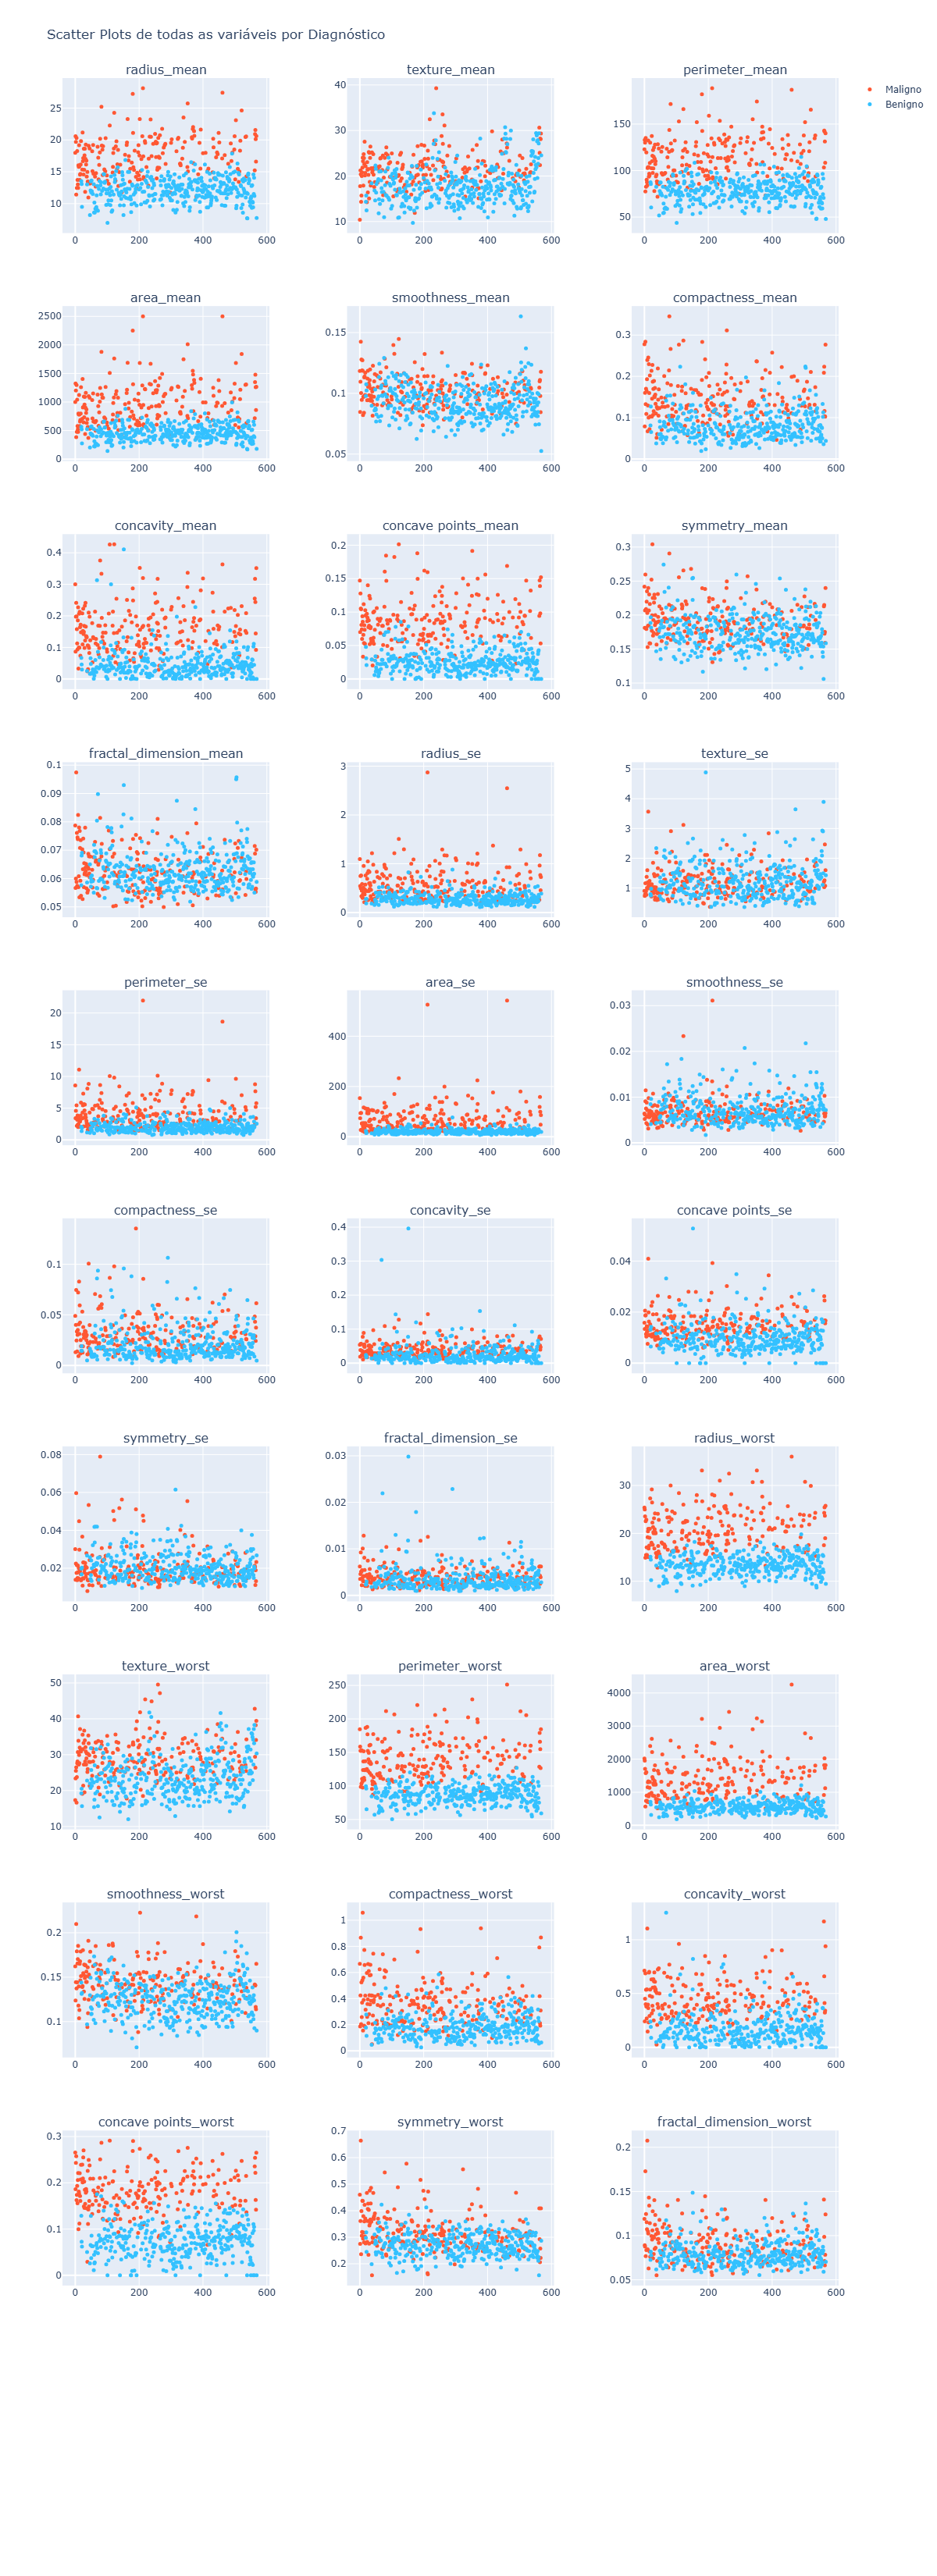

In [9]:
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=df_dataset.columns[2:],
    vertical_spacing=0.03, 
    horizontal_spacing=0.1
)

for idx, coluna in enumerate(df_dataset.columns[2:]):
    row = idx // n_cols + 1
    col = idx % n_cols + 1
    
    for diagnosis in df_dataset['diagnosis'].unique():
        df_filtrado = df_dataset[df_dataset['diagnosis'] == diagnosis]
        
        fig.add_trace(
            go.Scatter(
                x=df_filtrado.index,
                y=df_filtrado[coluna],
                mode='markers',
                name=diagnosis,
                marker=dict(color=color_maligono if diagnosis == 'Maligno' else color_benigno, size=5),
                showlegend=(idx == 0)
            ),
            row=row,
            col=col
        )

fig.update_layout(
    height=300 * n_rows, 
    width=width_graph,
    title_text="Scatter Plots de todas as variáveis por Diagnóstico",
    showlegend=True
)
fig.show()

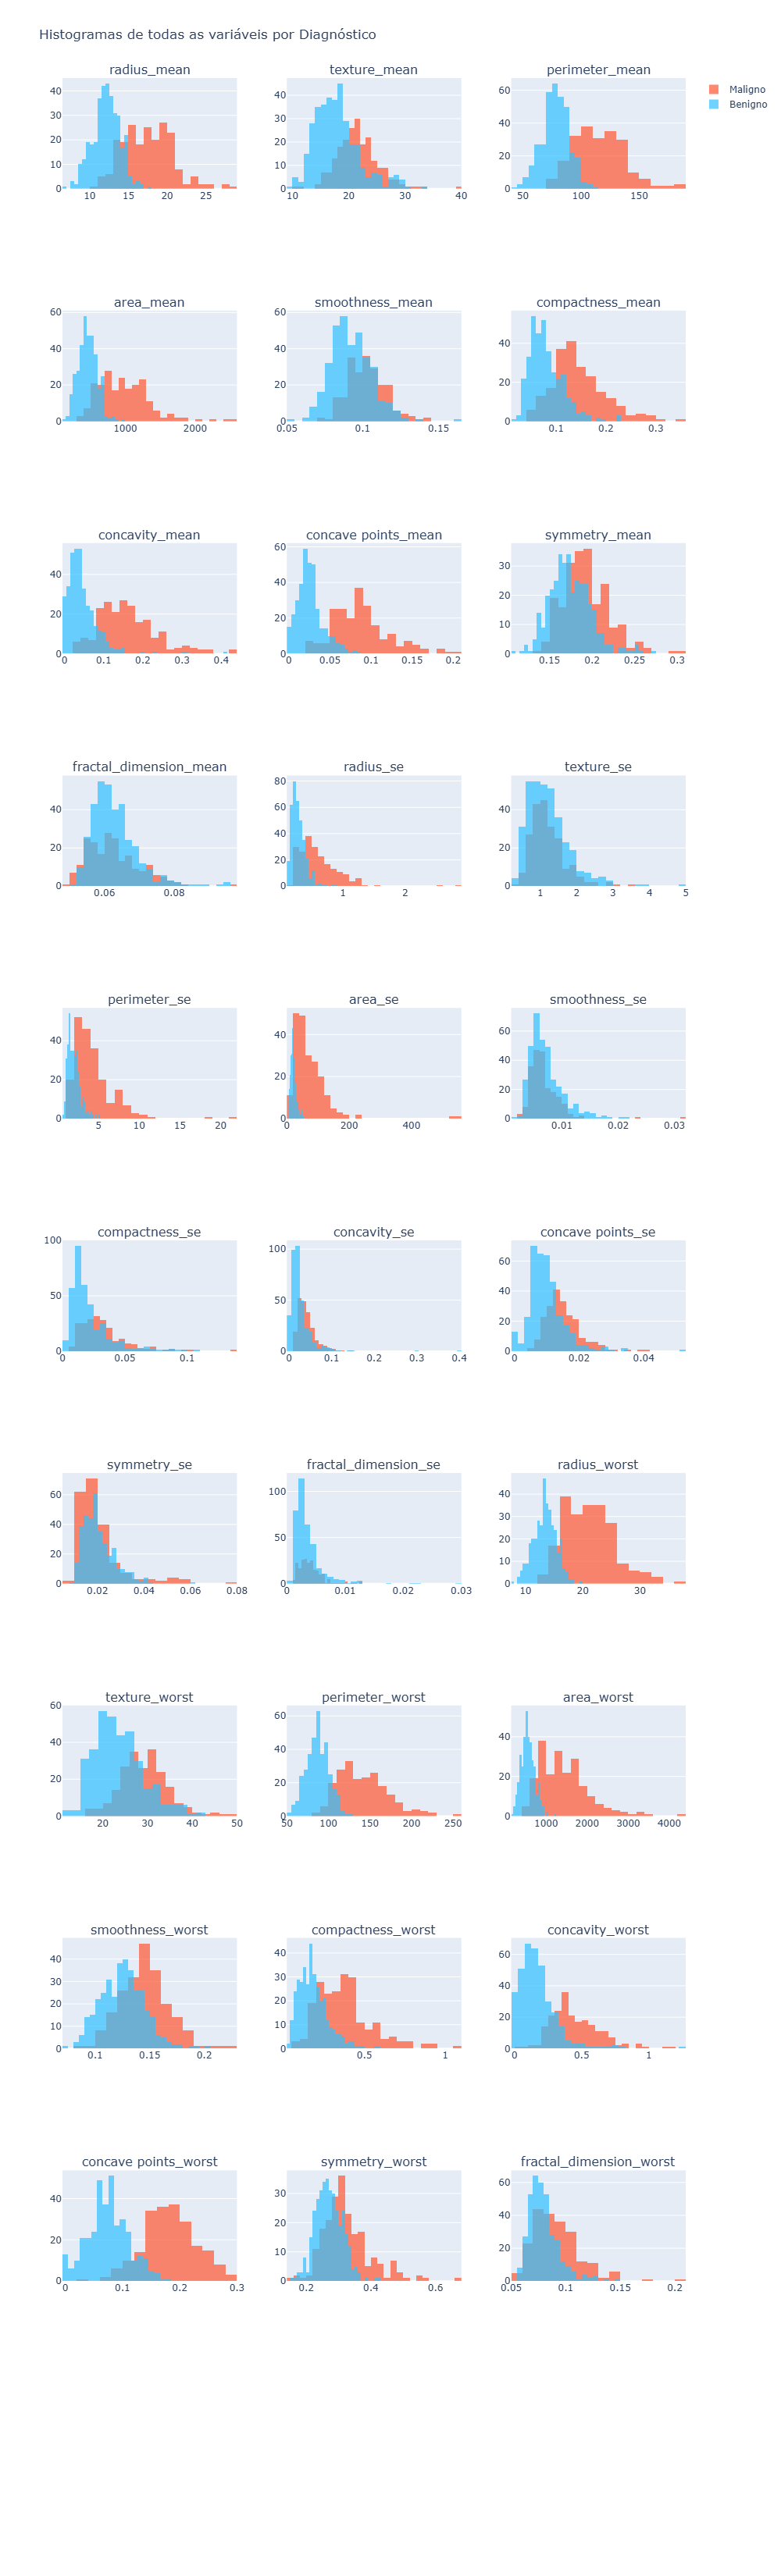

In [10]:
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=df_dataset.columns[2:],
    vertical_spacing=0.05,
    horizontal_spacing=0.08
)

for idx, coluna in enumerate(df_dataset.columns[2:]):
    row = idx // n_cols + 1
    col = idx % n_cols + 1
    
    for diagnosis in df_dataset['diagnosis'].unique():
        df_filtrado = df_dataset[df_dataset['diagnosis'] == diagnosis]
        fig.add_trace(
            go.Histogram(
                x=df_filtrado[coluna],
                name=diagnosis,
                marker=dict(color=color_maligono if diagnosis == 'Maligno' else color_benigno),
                opacity=0.7,
                showlegend=(idx == 0)
            ),
            row=row,
            col=col
        )

fig.update_layout(
    height=300 * n_rows, 
    width=1000,
    title_text="Histogramas de todas as variáveis por Diagnóstico",
    showlegend=True,
    barmode='overlay' 
)
fig.show()

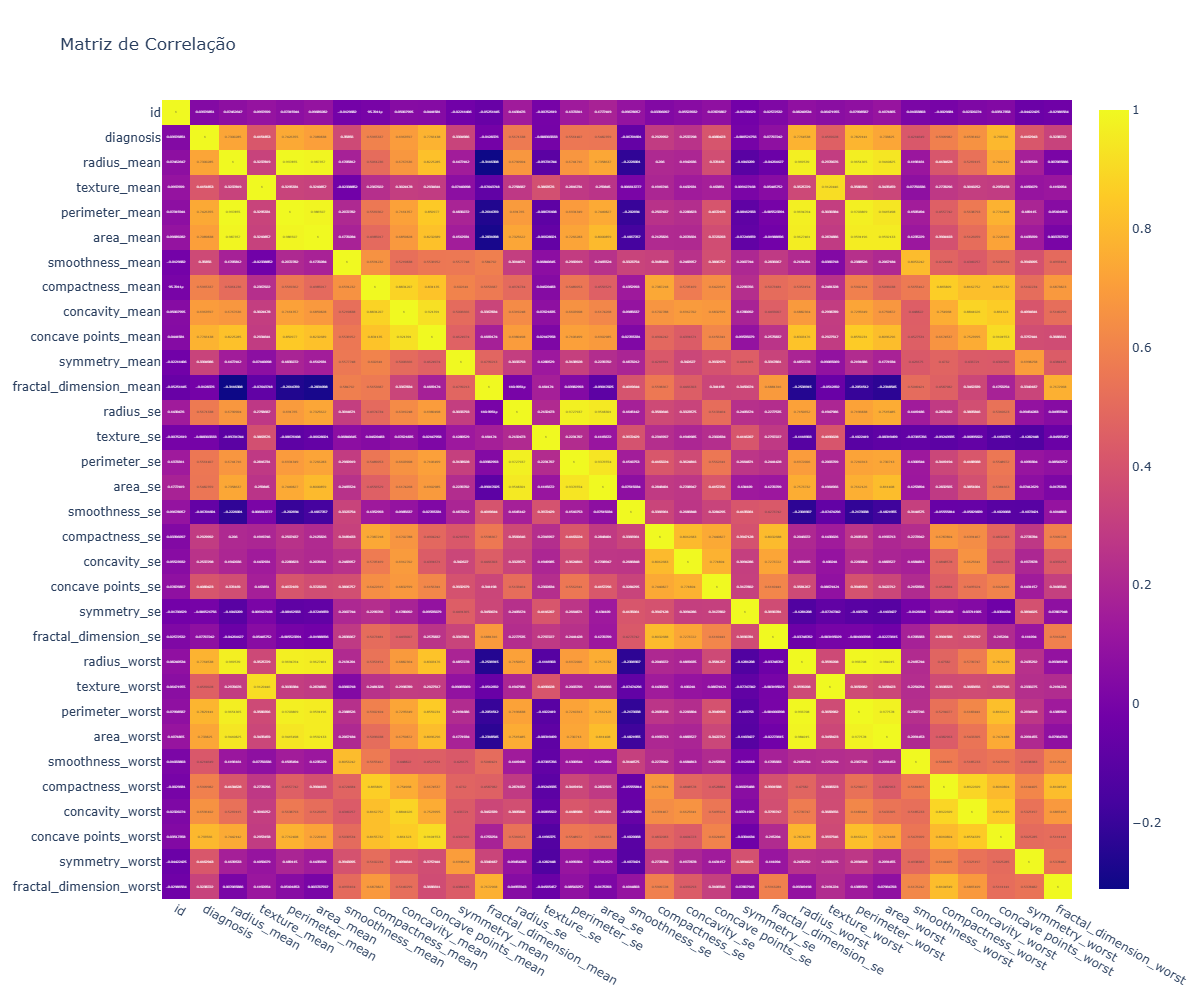

In [11]:
# Criar cópia e converter diagnosis para numérico
df_numeric = df_dataset.copy()
df_numeric['diagnosis'] = df_numeric['diagnosis'].map({'Maligno': 1, 'Benigno': 0}).astype(int)

fig = px.imshow(
    df_numeric.corr(), 
    text_auto=True, 
    aspect="auto", 
    title='Matriz de Correlação',
    height=1000,
    width=width_graph,
)


fig.show()

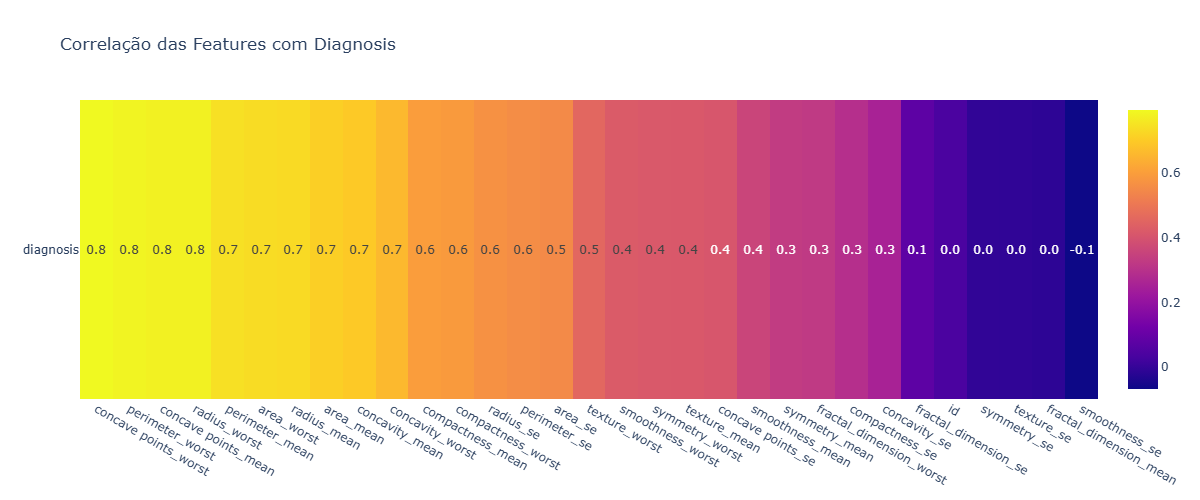

In [12]:
corr_diagnosis = df_numeric.corr()['diagnosis'].drop('diagnosis').sort_values(ascending=False)
corr_df = pd.DataFrame({
    'Feature': corr_diagnosis.index,
    'Correlação': corr_diagnosis.values
})

fig = px.imshow(
    corr_diagnosis.values.reshape(1, -1),
    x=corr_diagnosis.index,
    y=['diagnosis'],
    text_auto='.1f', 

    aspect="auto",
    title='Correlação das Features com Diagnosis',
    width=width_graph,
)

fig.show()

In [13]:
dados_treino = df_dataset.sample(frac=0.8, random_state=42)
dados_teste = df_dataset.drop(dados_treino.index)
display(dados_treino.head())
display(dados_teste.head())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
204,87930,Benigno,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,859575,Maligno,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,8670,Maligno,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,907915,Benigno,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,921385,Benigno,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
1,842517,Maligno,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902
8,844981,Maligno,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720
13,846381,Maligno,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,...,16.84,27.66,112.00,876.5,0.1131,0.1924,0.2322,0.11190,0.2809,0.06287
14,84667401,Maligno,13.73,22.61,93.60,578.3,0.11310,0.22930,0.21280,0.08025,...,15.03,32.01,108.80,697.7,0.1651,0.7725,0.6943,0.22080,0.3596,0.14310
20,8510653,Benigno,13.08,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,...,14.50,20.49,96.09,630.5,0.1312,0.2776,0.1890,0.07283,0.3184,0.08183


In [14]:
x_train_norm = dados_treino.drop('diagnosis', axis=1)
y_train_norm = dados_treino['diagnosis']
x_test_norm = dados_teste.drop('diagnosis', axis=1)
y_test_norm = dados_teste['diagnosis']

x_train_no_norm = dados_treino.drop('diagnosis', axis=1)
y_train_no_norm = dados_treino['diagnosis']
x_test_no_norm = dados_teste.drop('diagnosis', axis=1)
y_test_no_norm = dados_teste['diagnosis']

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_norm)
x_test_norm = scaler.transform(x_test_norm)

x_train_norm = pd.DataFrame(x_train_norm, columns=x_train_no_norm.columns)
x_test_norm = pd.DataFrame(x_test_norm, columns=x_test_no_norm.columns)

display(x_train_norm.head())
display(x_train_no_norm.head())

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.253169,-0.455129,-0.169797,-0.433241,-0.487315,0.239337,0.020782,-0.110130,-0.267426,0.398441,...,-0.256802,-0.184102,-0.324600,-0.351588,0.458880,-0.110731,-0.027663,-0.185544,0.164457,0.191523
1,-0.247344,1.404797,0.477081,1.336514,1.424423,-0.446966,-0.033579,0.237538,0.794985,-0.820062,...,1.801632,0.141368,1.759229,1.790008,-0.574575,-0.137885,-0.020035,0.992655,-0.572366,-1.016597
2,-0.253767,0.404404,0.040259,0.424784,0.300271,0.924921,0.330078,0.717679,0.829970,0.419756,...,0.636088,0.044062,0.536080,0.510206,0.991132,-0.100387,0.506274,0.574044,-0.117222,-0.217147
3,-0.246980,-0.475252,-0.389402,-0.417421,-0.528907,0.652123,0.504408,-0.142968,-0.530328,-0.006543,...,-0.691800,-0.474341,-0.516724,-0.643779,0.565330,0.051544,-0.155426,-0.608722,-0.564409,0.531988
4,-0.246878,-0.722475,-1.162791,-0.701348,-0.720346,0.252976,0.137002,-0.267855,-0.583063,0.018325,...,-0.820842,-1.016231,-0.839814,-0.748326,0.099610,-0.278825,-0.444324,-0.677526,-0.925659,-0.152856


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
204,87930,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,859575,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,8670,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,907915,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,921385,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


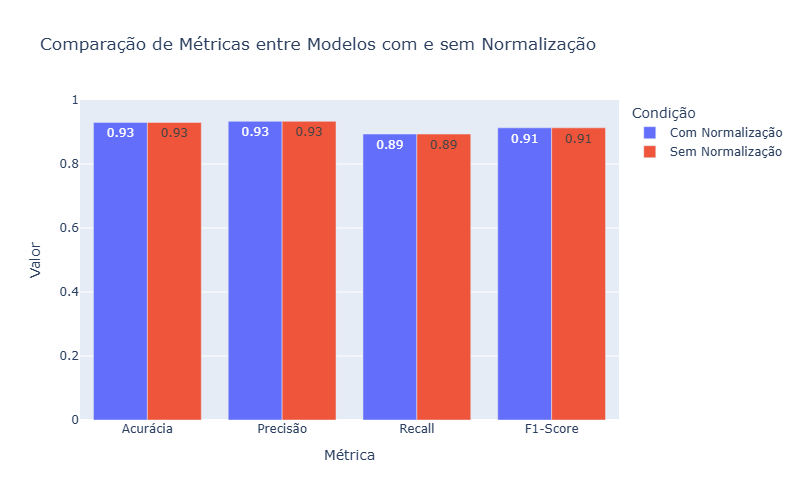

In [15]:
modelo_norm = DecisionTreeClassifier(criterion='entropy',random_state=42)
modelo_no_norm = DecisionTreeClassifier(criterion='entropy',random_state=42)

modelo_norm.fit(x_train_norm, y_train_norm)
modelo_no_norm.fit(x_train_no_norm, y_train_no_norm);

predicoes_norm = modelo_norm.predict(x_test_norm)
predicoes_no_norm = modelo_no_norm.predict(x_test_no_norm)

accuracy_norn, precision_norn, recall_norn, f1_norn = (
    accuracy_score(y_test_norm, predicoes_norm),
    precision_score(y_test_norm, predicoes_norm, pos_label='Maligno'),
    recall_score(y_test_norm, predicoes_norm, pos_label='Maligno'),
    f1_score(y_test_norm, predicoes_norm, pos_label='Maligno')
)

accuracy_no_norm, precision_no_norm, recall_no_norm, f1_no_norm = (
    accuracy_score(y_test_no_norm, predicoes_no_norm),
    precision_score(y_test_no_norm, predicoes_no_norm, pos_label='Maligno'),
    recall_score(y_test_no_norm, predicoes_no_norm, pos_label='Maligno'),
    f1_score(y_test_no_norm, predicoes_no_norm, pos_label='Maligno')
)

metricas = pd.DataFrame({
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score'],
    'Com Normalização': [accuracy_norn, precision_norn, recall_norn, f1_norn],
    'Sem Normalização': [accuracy_no_norm, precision_no_norm, recall_no_norm, f1_no_norm]
})

metricas_melted = metricas.melt(id_vars='Métrica', var_name='Condição', value_name='Valor')
fig = px.bar(
    metricas_melted, 
    x='Métrica', 
    y='Valor', 
    color='Condição', 
    barmode='group',
    title='Comparação de Métricas entre Modelos com e sem Normalização',
    text_auto='.2f',
    width=800,
    height=500
)
fig.update_layout(yaxis=dict(range=[0, 1]))
fig.show()

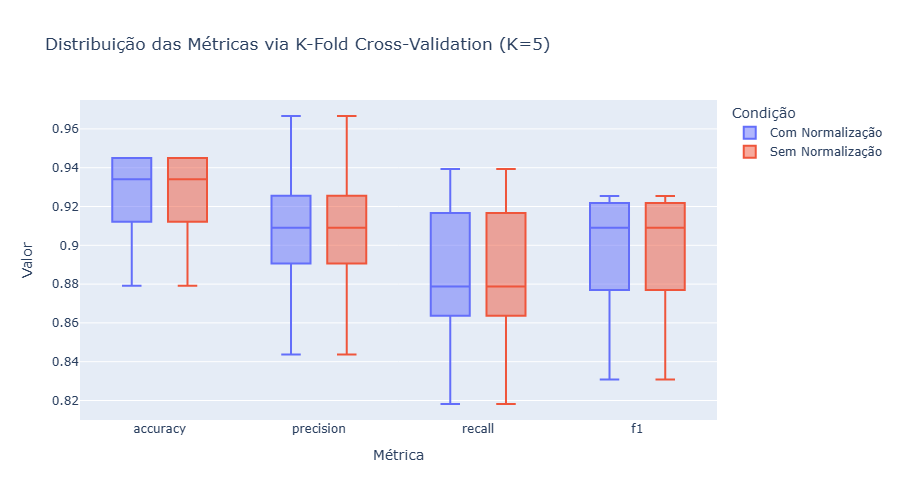


Métricas - Com Normalização:


,accuracy,precision,recall,f1
mean,0.925275,0.907504,0.884848,0.895635
std,0.027362,0.043552,0.044947,0.038435



Métricas - Sem Normalização:


,accuracy,precision,recall,f1
mean,0.925275,0.907504,0.884848,0.895635
std,0.027362,0.043552,0.044947,0.038435


In [16]:

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='Maligno'),
    'recall': make_scorer(recall_score, pos_label='Maligno'),
    'f1': make_scorer(f1_score, pos_label='Maligno')
}

modelo_dt_norm = DecisionTreeClassifier(criterion='entropy', random_state=42)
modelo_dt_no_norm = DecisionTreeClassifier(criterion='entropy', random_state=42)

scores_kfold_norm = cross_validate(
    modelo_dt_norm, 
    X=x_train_norm, 
    y=y_train_norm, 
    cv=kf, 
    scoring=scoring,
    return_train_score=False
)

scores_kfold_no_norm = cross_validate(
    modelo_dt_no_norm, 
    X=x_train_no_norm, 
    y=y_train_no_norm, 
    cv=kf, 
    scoring=scoring,
    return_train_score=False
)

scores_kfold_norm_df = pd.DataFrame({
    'accuracy': scores_kfold_norm['test_accuracy'],
    'precision': scores_kfold_norm['test_precision'],
    'recall': scores_kfold_norm['test_recall'],
    'f1': scores_kfold_norm['test_f1']
})

scores_kfold_no_norm_df = pd.DataFrame({
    'accuracy': scores_kfold_no_norm['test_accuracy'],
    'precision': scores_kfold_no_norm['test_precision'],
    'recall': scores_kfold_no_norm['test_recall'],
    'f1': scores_kfold_no_norm['test_f1']
})

scores_kfold_norm_df['Condição'] = 'Com Normalização'
scores_kfold_no_norm_df['Condição'] = 'Sem Normalização'

scores_kfold_combined = pd.concat([scores_kfold_norm_df, scores_kfold_no_norm_df])
scores_kfold_melted = scores_kfold_combined.melt(id_vars='Condição', var_name='Métrica', value_name='Valor')

fig = px.box(
    scores_kfold_melted, 
    x='Métrica', 
    y='Valor', 
    color='Condição', 
    title='Distribuição das Métricas via K-Fold Cross-Validation (K=5)',
    width=900,
    height=500
)
fig.show()

print("\nMétricas - Com Normalização:")
display(scores_kfold_norm_df.describe().loc[['mean', 'std']])
print("\nMétricas - Sem Normalização:")
display(scores_kfold_no_norm_df.describe().loc[['mean', 'std']])

In [17]:
loo = LeaveOneOut()
scoring = {
    'accuracy': 'accuracy',
    # 'precision': 'precision_macro',
    # 'recall': 'recall_macro',
    # 'f1': 'f1_macro'
}

modelo_loocv_norm = DecisionTreeClassifier(criterion='entropy', random_state=42)
modelo_loocv_no_norm = DecisionTreeClassifier(criterion='entropy', random_state=42)

scores_loocv_norm = cross_validate(
    modelo_loocv_norm,
    X=x_train_norm,
    y=y_train_norm,
    cv=loo,
    scoring=scoring,
    return_train_score=False
)

scores_loocv_no_norm = cross_validate(
    modelo_loocv_no_norm,
    X=x_train_no_norm,
    y=y_train_no_norm,
    cv=loo,
    scoring=scoring,
    return_train_score=False
)

scores_loocv_norm_df = pd.DataFrame({
    'accuracy': scores_loocv_norm['test_accuracy'],
})

scores_loocv_no_norm_df = pd.DataFrame({
    'accuracy': scores_loocv_no_norm['test_accuracy'],
})

scores_loocv_norm_df['Condição'] = 'Com Normalização'
scores_loocv_no_norm_df['Condição'] = 'Sem Normalização'

print("\nMétricas - Com Normalização:")
display(scores_loocv_norm_df.describe())
print("\nMétricas - Sem Normalização:")
display(scores_loocv_no_norm_df.describe())


Métricas - Com Normalização:


,accuracy
count,455.000000
mean,0.931868
std,0.252249
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000



Métricas - Sem Normalização:


,accuracy
count,455.000000
mean,0.931868
std,0.252249
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000
